In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pairs = [['IEMG', 'EEM'], ['ARKK', 'ARKW'], ['TLT', 'SPTL'], ['SHY', 'VGSH'], ['SOXX', 'ITA']]

downloadable_tickers = [ticker for pair in pairs for ticker in pair]

training_data = yf.download(downloadable_tickers, start = '2015-01-01', end = '2020-01-01')['Close']
testing_data = yf.download(downloadable_tickers, start = '2020-01-02', end = '2020-12-31')['Close']

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_4710/1115248133.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  training_data = yf.download(downloadable_tickers, start = '2015-01-01', end = '2020-01-01')['Close']
[*********************100%***********************]  10 of 10 completed
/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_4710/1115248133.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  testing_data = yf.download(downloadable_tickers, start = '2020-01-02', end = '2020-12-31')['Close']
[*********************100%***********************]  10 of 10 completed


In [6]:
def zscore_calc_test(series, mean, std):
    return (series - mean) / std

def zscore_calc_train(series):
    return (series - series.mean()) / series.std(), series.mean(), series.std()

def create_features(spread, pair, window = 5):
    df = pd.DataFrame({'spread': spread})
    df['z-score'] = (df['spread'] - df['spread'].mean()) / df['spread'].std()
    df['z-score_lag1'] = df['z-score'].shift(1)
    df['spread_lag1'] = df['spread'].shift(1)
    df['rolling_mean'] = df['spread'].rolling(window).mean()
    df['rolling_std'] = df['spread'].rolling(window).std()
    df['volatility'] = df['spread'].pct_change().rolling(window).std()
    df = df.dropna()
    return df

training_spreads = {}
testing_spreads = {}

X_train_dict = {}
y_train_dict = {}
X_test_dict = {}
y_test_dict = {}

for etf1, etf2 in pairs:

    pair_name = f'{etf1}_{etf2}'

    train_z1, mean_z1, std_z1 = zscore_calc_train(training_data[etf1])
    train_z2, mean_z2, std_z2 = zscore_calc_train(training_data[etf2])

    test_z1 = zscore_calc_test(testing_data[etf1], mean_z1, std_z1)
    test_z2 = zscore_calc_test(testing_data[etf2], mean_z2, std_z2)

    training_spread, testing_spread = train_z1 - train_z2, test_z1 - test_z2
    training_spreads[pair_name], testing_spreads[pair_name] = training_spread, testing_spread

    train_features = create_features(training_spread, pair_name)
    test_features = create_features(testing_spread, pair_name)

    train_features['label'] = (train_features['z-score'] * train_features['z-score_lag1'] < 0).astype(int)
    test_features['label'] = (test_features['z-score'] * test_features['z-score_lag1'] < 0).astype(int)

    X_train_dict[pair_name] = train_features.drop(columns=['label'])
    y_train_dict[pair_name] = train_features['label']
    X_test_dict[pair_name] = test_features.drop(columns=['label'])
    y_test_dict[pair_name] = test_features['label']


training_spreads_df = pd.DataFrame(training_spreads)
testing_spreads_df = pd.DataFrame(testing_spreads)

In [7]:
def predict_mean_reversion_label(spread, window = 3, threshold = 0.02):
    labels = []
    mean = spread.mean()

    for i in range(len(spread)):
        future_spread = spread[i + 1 : i + 1 + window]
        if len(future_spread) < window:
            labels.append(np.nan)
        elif any(abs(j - mean) < threshold for j in future_spread):
            labels.append(1)
        else:
            labels.append(0)

    return pd.Series(labels, index = spread.index)

In [8]:
def create_sequences(data, window_size):
    X, y  = [], []

    for i in range(len(data) - window_size):
        X.append(data[i : i + window_size])
        y.append(data[i + window_size])

    X_1 = np.array(X)
    y_1 = np.array(y)

    return torch.tensor(X_1, dtype = torch.float32).unsqueeze(-1), torch.tensor(y_1, dtype = torch.float32).unsqueeze(-1)

In [9]:
class ClassificationLSTM(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 50, num_layers = 1):
        super(ClassificationLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.linear(out)
        out = self.sigmoid(out)
        return out.squeeze()

In [10]:
def train_model(model, train_loader, criterion, optimizer, epochs = 50, device = 'cpu'):
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_loader):.4f}")

In [11]:
def evaluate_model(model, test_loader, device = 'cpu'):
    model.eval()
    all_preds = []
    all_true = []
    
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            all_preds.append(preds.cpu())
            all_true.append(yb.cpu())
    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_true).numpy()
    y_pred_label = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_true, y_pred_label)
    print("Test Accuracy:", accuracy)
    return y_true, y_pred, y_pred_label

In [12]:
def plot_labels(spread, y_pred_label, pair_name):
    aligned_spread = spread[-len(y_pred_label):]
    predicted_points = aligned_spread[y_pred_label == 1]

    plt.figure(figsize=(12, 5))
    sns.lineplot(x=aligned_spread.index, y=aligned_spread.values, label='Spread', color='black')
    sns.scatterplot(x=predicted_points.index, y=predicted_points.values, color='green', label='Predicted Reversion', s=100, marker='o')
    plt.title(f"Predicted Mean Reversions of {pair_name}")
    plt.xlabel("Date")
    plt.ylabel("Spread")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [13]:
def print_confusion_matrix(y_true, y_pred_label):
    cm = confusion_matrix(y_true, y_pred_label, labels = [0, 1])
    print("Confusion Matrix:")
    print(cm)

In [14]:
def print_f1(y_true, y_pred_label):
    f1 = f1_score(y_true, y_pred_label)
    print(f"F1 Score: {f1:.4f}")

In [15]:
def run_pair(pair_name, train_spread, test_spread, window_size=30, threshold=0.2, epochs=50, device='cpu'):
    train_labels_raw = predict_mean_reversion_label(train_spread)
    test_labels_raw = predict_mean_reversion_label(test_spread)

    train_mask = train_labels_raw.notna()
    test_mask = test_labels_raw.notna()

    train_spread_aligned = train_spread[train_mask]
    train_labels_aligned = train_labels_raw[train_mask]

    test_spread_aligned = test_spread[test_mask]
    test_labels_aligned = test_labels_raw[test_mask]
    
    X_train, _ = create_sequences(train_spread_aligned.values, window_size)
    y_train = torch.tensor(train_labels_aligned.values[window_size:], dtype=torch.float32).unsqueeze(-1)
    y_train = y_train[:len(X_train)]

    X_test, _ = create_sequences(test_spread_aligned. values, window_size)
    y_test = torch.tensor(test_labels_aligned.values[window_size:], dtype=torch.float32).unsqueeze(-1)
    y_test = y_test[:len(X_test)]

    y_train = y_train.float()
    y_test = y_test.float()
    
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle = False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle = False)
    
    model = ClassificationLSTM().to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    print(f"\nTraining model for pair: {pair_name}")
    train_model(model, train_loader, criterion, optimizer, epochs=epochs, device=device)
    
    print(f"\nEvaluating model for pair: {pair_name}")
    y_true, y_pred, y_pred_label = evaluate_model(model, test_loader, device=device)

    plot_labels(test_spread, y_pred_label, pair_name)

    print_confusion_matrix(y_true, y_pred_label)

    print_f1(y_true, y_pred_label)

    labels = predict_mean_reversion_label(testing_spreads_df[pair_name], window=5, threshold=0.1)
    print(f"Label distribution for {pair_name}:")
    print(labels.value_counts(dropna=True))
    
    return model, y_true, y_pred


Training model for pair: IEMG_EEM
Epoch 1/50 - Loss: 0.6608
Epoch 2/50 - Loss: 0.6402
Epoch 3/50 - Loss: 0.6198
Epoch 4/50 - Loss: 0.6135
Epoch 5/50 - Loss: 0.6100
Epoch 6/50 - Loss: 0.6092
Epoch 7/50 - Loss: 0.6089
Epoch 8/50 - Loss: 0.6086
Epoch 9/50 - Loss: 0.6084
Epoch 10/50 - Loss: 0.6082
Epoch 11/50 - Loss: 0.6080
Epoch 12/50 - Loss: 0.6079
Epoch 13/50 - Loss: 0.6078
Epoch 14/50 - Loss: 0.6077
Epoch 15/50 - Loss: 0.6076
Epoch 16/50 - Loss: 0.6075
Epoch 17/50 - Loss: 0.6074
Epoch 18/50 - Loss: 0.6073
Epoch 19/50 - Loss: 0.6072
Epoch 20/50 - Loss: 0.6071
Epoch 21/50 - Loss: 0.6071
Epoch 22/50 - Loss: 0.6070
Epoch 23/50 - Loss: 0.6069
Epoch 24/50 - Loss: 0.6069
Epoch 25/50 - Loss: 0.6068
Epoch 26/50 - Loss: 0.6068
Epoch 27/50 - Loss: 0.6067
Epoch 28/50 - Loss: 0.6067
Epoch 29/50 - Loss: 0.6066
Epoch 30/50 - Loss: 0.6066
Epoch 31/50 - Loss: 0.6065
Epoch 32/50 - Loss: 0.6065
Epoch 33/50 - Loss: 0.6064
Epoch 34/50 - Loss: 0.6064
Epoch 35/50 - Loss: 0.6063
Epoch 36/50 - Loss: 0.6063
Ep

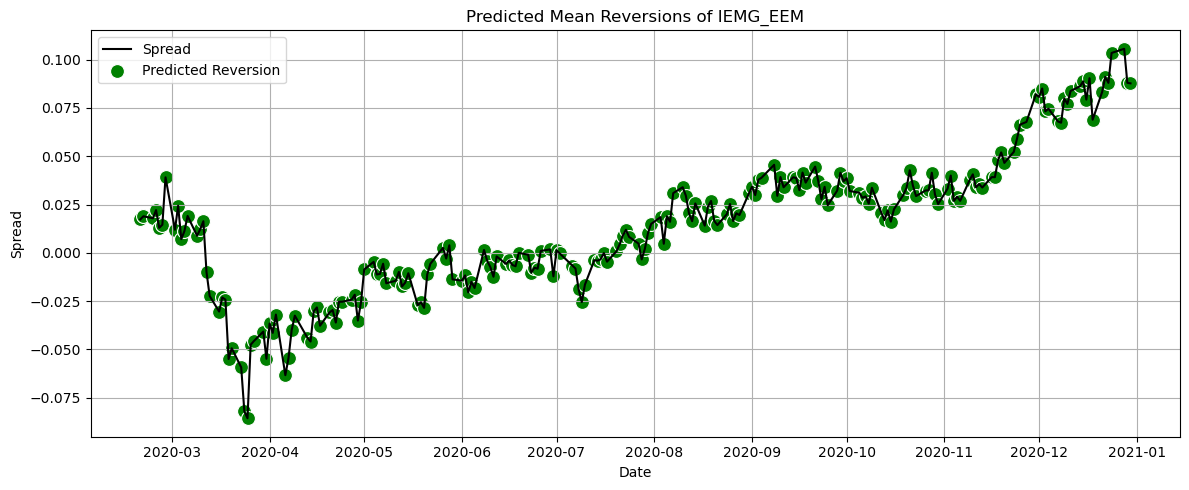

Confusion Matrix:
[[  0  86]
 [  0 133]]
F1 Score: 0.7557
Label distribution for IEMG_EEM:
1.0    247
Name: count, dtype: int64

Training model for pair: ARKK_ARKW
Epoch 1/50 - Loss: 0.6888
Epoch 2/50 - Loss: 0.6631
Epoch 3/50 - Loss: 0.6418
Epoch 4/50 - Loss: 0.6388
Epoch 5/50 - Loss: 0.6378
Epoch 6/50 - Loss: 0.6375
Epoch 7/50 - Loss: 0.6372
Epoch 8/50 - Loss: 0.6370
Epoch 9/50 - Loss: 0.6369
Epoch 10/50 - Loss: 0.6368
Epoch 11/50 - Loss: 0.6367
Epoch 12/50 - Loss: 0.6366
Epoch 13/50 - Loss: 0.6365
Epoch 14/50 - Loss: 0.6364
Epoch 15/50 - Loss: 0.6364
Epoch 16/50 - Loss: 0.6363
Epoch 17/50 - Loss: 0.6363
Epoch 18/50 - Loss: 0.6362
Epoch 19/50 - Loss: 0.6362
Epoch 20/50 - Loss: 0.6361
Epoch 21/50 - Loss: 0.6361
Epoch 22/50 - Loss: 0.6361
Epoch 23/50 - Loss: 0.6360
Epoch 24/50 - Loss: 0.6360
Epoch 25/50 - Loss: 0.6360
Epoch 26/50 - Loss: 0.6359
Epoch 27/50 - Loss: 0.6359
Epoch 28/50 - Loss: 0.6359
Epoch 29/50 - Loss: 0.6358
Epoch 30/50 - Loss: 0.6358
Epoch 31/50 - Loss: 0.6358
Epoch 32

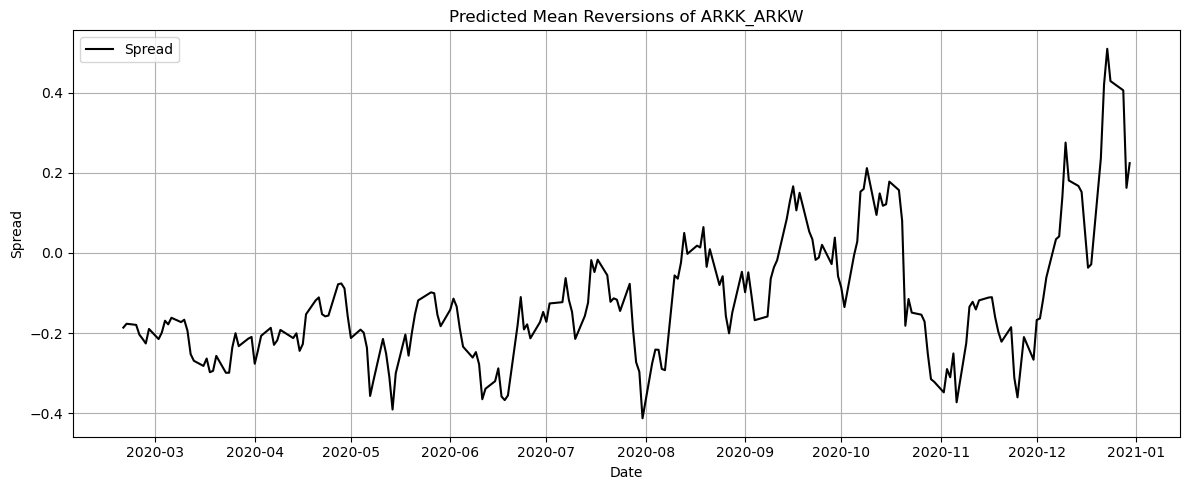

Confusion Matrix:
[[169   0]
 [ 50   0]]
F1 Score: 0.0000
Label distribution for ARKK_ARKW:
1.0    199
0.0     48
Name: count, dtype: int64

Training model for pair: TLT_SPTL
Epoch 1/50 - Loss: 0.6985
Epoch 2/50 - Loss: 0.5841
Epoch 3/50 - Loss: 0.4201
Epoch 4/50 - Loss: 0.4435
Epoch 5/50 - Loss: 0.4387
Epoch 6/50 - Loss: 0.4342
Epoch 7/50 - Loss: 0.4327
Epoch 8/50 - Loss: 0.4324
Epoch 9/50 - Loss: 0.4322
Epoch 10/50 - Loss: 0.4320
Epoch 11/50 - Loss: 0.4318
Epoch 12/50 - Loss: 0.4316
Epoch 13/50 - Loss: 0.4315
Epoch 14/50 - Loss: 0.4313
Epoch 15/50 - Loss: 0.4312
Epoch 16/50 - Loss: 0.4311
Epoch 17/50 - Loss: 0.4310
Epoch 18/50 - Loss: 0.4310
Epoch 19/50 - Loss: 0.4309
Epoch 20/50 - Loss: 0.4308
Epoch 21/50 - Loss: 0.4308
Epoch 22/50 - Loss: 0.4307
Epoch 23/50 - Loss: 0.4307
Epoch 24/50 - Loss: 0.4306
Epoch 25/50 - Loss: 0.4306
Epoch 26/50 - Loss: 0.4305
Epoch 27/50 - Loss: 0.4305
Epoch 28/50 - Loss: 0.4305
Epoch 29/50 - Loss: 0.4304
Epoch 30/50 - Loss: 0.4304
Epoch 31/50 - Loss: 0.43

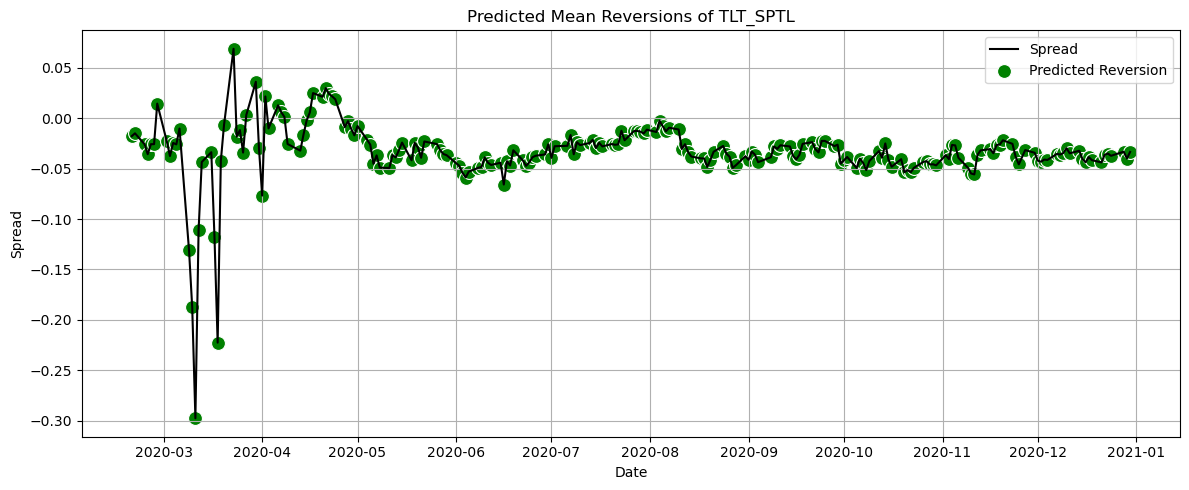

Confusion Matrix:
[[  0  17]
 [  0 202]]
F1 Score: 0.9596
Label distribution for TLT_SPTL:
1.0    247
Name: count, dtype: int64

Training model for pair: SHY_VGSH
Epoch 1/50 - Loss: 0.6554
Epoch 2/50 - Loss: 0.6134
Epoch 3/50 - Loss: 0.5958
Epoch 4/50 - Loss: 0.5599
Epoch 5/50 - Loss: 0.5591
Epoch 6/50 - Loss: 0.5571
Epoch 7/50 - Loss: 0.5557
Epoch 8/50 - Loss: 0.5548
Epoch 9/50 - Loss: 0.5542
Epoch 10/50 - Loss: 0.5537
Epoch 11/50 - Loss: 0.5532
Epoch 12/50 - Loss: 0.5528
Epoch 13/50 - Loss: 0.5524
Epoch 14/50 - Loss: 0.5521
Epoch 15/50 - Loss: 0.5518
Epoch 16/50 - Loss: 0.5515
Epoch 17/50 - Loss: 0.5513
Epoch 18/50 - Loss: 0.5510
Epoch 19/50 - Loss: 0.5508
Epoch 20/50 - Loss: 0.5506
Epoch 21/50 - Loss: 0.5504
Epoch 22/50 - Loss: 0.5502
Epoch 23/50 - Loss: 0.5500
Epoch 24/50 - Loss: 0.5498
Epoch 25/50 - Loss: 0.5497
Epoch 26/50 - Loss: 0.5495
Epoch 27/50 - Loss: 0.5493
Epoch 28/50 - Loss: 0.5492
Epoch 29/50 - Loss: 0.5490
Epoch 30/50 - Loss: 0.5489
Epoch 31/50 - Loss: 0.5487
Epoch 32/

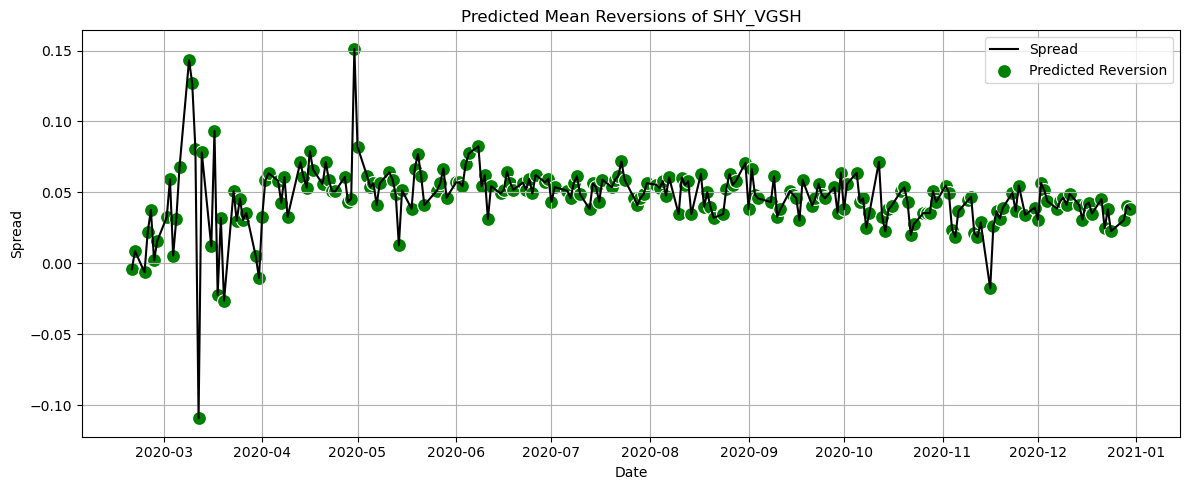

Confusion Matrix:
[[  0  11]
 [  0 208]]
F1 Score: 0.9742
Label distribution for SHY_VGSH:
1.0    247
Name: count, dtype: int64

Training model for pair: SOXX_ITA
Epoch 1/50 - Loss: 0.7062
Epoch 2/50 - Loss: 0.5901
Epoch 3/50 - Loss: 0.5841
Epoch 4/50 - Loss: 0.5683
Epoch 5/50 - Loss: 0.5633
Epoch 6/50 - Loss: 0.5641
Epoch 7/50 - Loss: 0.5641
Epoch 8/50 - Loss: 0.5637
Epoch 9/50 - Loss: 0.5634
Epoch 10/50 - Loss: 0.5632
Epoch 11/50 - Loss: 0.5630
Epoch 12/50 - Loss: 0.5629
Epoch 13/50 - Loss: 0.5628
Epoch 14/50 - Loss: 0.5626
Epoch 15/50 - Loss: 0.5625
Epoch 16/50 - Loss: 0.5624
Epoch 17/50 - Loss: 0.5623
Epoch 18/50 - Loss: 0.5622
Epoch 19/50 - Loss: 0.5621
Epoch 20/50 - Loss: 0.5620
Epoch 21/50 - Loss: 0.5619
Epoch 22/50 - Loss: 0.5619
Epoch 23/50 - Loss: 0.5618
Epoch 24/50 - Loss: 0.5617
Epoch 25/50 - Loss: 0.5616
Epoch 26/50 - Loss: 0.5615
Epoch 27/50 - Loss: 0.5615
Epoch 28/50 - Loss: 0.5614
Epoch 29/50 - Loss: 0.5612
Epoch 30/50 - Loss: 0.5621
Epoch 31/50 - Loss: 0.5610
Epoch 32/

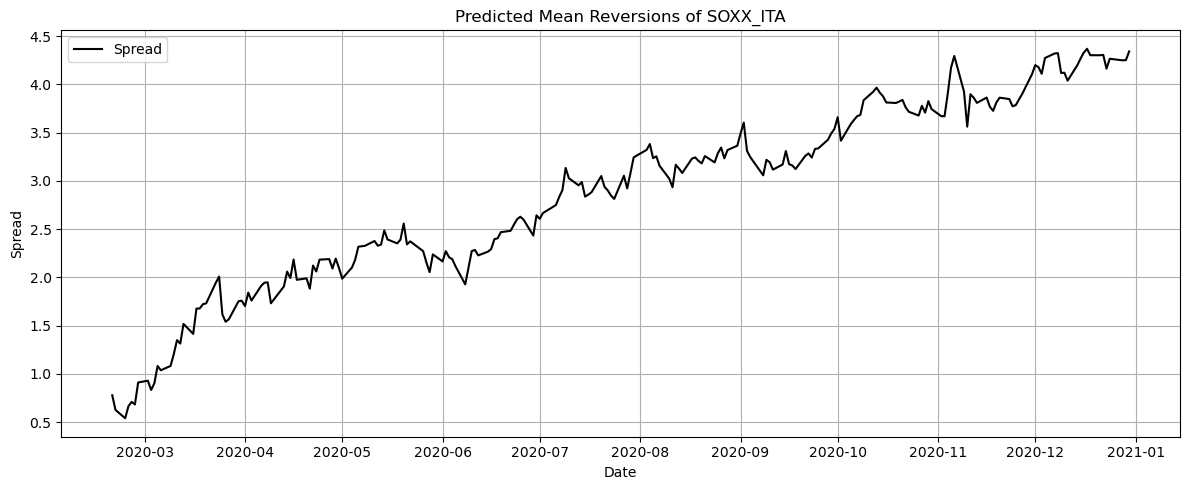

Confusion Matrix:
[[216   0]
 [  3   0]]
F1 Score: 0.0000
Label distribution for SOXX_ITA:
0.0    225
1.0     22
Name: count, dtype: int64
{'IEMG_EEM': {'model': ClassificationLSTM(
  (lstm): LSTM(1, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
), 'y_true': array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
    

In [16]:
results = {}


for pair_name in training_spreads_df.columns:
    model, y_true, y_pred = run_pair(
        pair_name,
        training_spreads_df[pair_name].dropna(),
        testing_spreads_df[pair_name].dropna(),
        window_size=30,
        threshold=0.2,
        epochs=50,
        device='cpu'
    )
    results[pair_name] = {'model': model, 'y_true': y_true, 'y_pred': y_pred}

print(results)